# Spam Classifer Kaggle Competition 98.6% accuracy solution


In is notebook I will be completing the challenge listed at https://inclass.kaggle.com/c/adcg-ss14-challenge-02-spam-mails-detection. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from bs4 import BeautifulSoup
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.feature_extraction.text import CountVectorizer

## Step 1: Collect Data

1. Download git repo https://github.com/tie304/machine-learning/tree/master/email-spam-classifier-keras
2. Download Kaggle compititon data here: https://inclass.kaggle.com/c/adcg-ss14-challenge-02-spam-mails-detection. 
3. Run ExtractContent.py provided with the kaggle challenge, with <strong>with Python 2</strong> for each of the training and testing directories after unzipping. This will extract the body of the .eml files
4. Run format_data.py <strong>with Python 3</strong>  in order to extract email: subject, from and body sections into a csv <strong>(note:) You will have to change parameters for dir locations at the top of extract_data.py</strong>.

 <br> <br> My parser extracts both the <strong>"subject"</strong> ,<strong>"from"</strong> and <strong>body</strong> that's the data we'll use to train our model. The extractor will extract the data into "train_data.csv" and "test_data.csv"

## Step 2: Preprocess Data

Read data in

In [2]:
train_data = pd.read_csv('train_data.csv',index_col=0)
test_data = pd.read_csv('test_data.csv',index_col=0)

Remove 'b on begining of string training and test data strings

In [3]:

train_data['body'] = train_data['body'].str.slice(1,-1)
test_data['body'] = test_data['body'].str.slice(1,-1)


Replace missing "subject" columns with <strong>No Subject</strong> and missing "from" columns with <strong>?</strong>

In [4]:

print("train missing values",train_data.isnull().values.sum())
print("test missing values",test_data.isnull().values.sum())

#get indexes of missing values
train_indices = np.where(train_data['subject'].isna())
test_indices = np.where(test_data['subject'].isna())

#fill missing subject values
train_data['subject'] = train_data['subject'].fillna('no subject')
test_data['subject'] = test_data['subject'].fillna('no subject')
#vill missing training values
train_data['from'] = train_data['from'].fillna('?')
test_data['from'] = test_data['from'].fillna('?')

print('____________________________________')
print("train missing values",train_data.isnull().values.sum())
print("test missing values",test_data.isnull().values.sum())
    


train missing values 3
test missing values 4
____________________________________
train missing values 0
test missing values 0


Vectorize columns with <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">CountVectorizer</a> from sklean. Durring this step I'll be vectorizing both columns in order to feed it through the neural net. We need to vectorize each column we want to pass through separately. <br><br>

Step 1: Create n instances of count vectorizer for each column <br>
Step 2: Fit on test data ONLY for each column<br>
Step 3: Transform each column using .transform<br>
Step 4: Concatenate each column togeather<br>


In [5]:
"""
function that transforms N columns in a dataset to vectors and then concats them.
Must have == number of training and test data columns



Args:
    VectorizerClass: type of vectorizer to use
    train_data: your training data
    test_data: your test data
    
Returns vectorized columns of dataset for test and train data
"""

def vectorize_columns(VectorizerClass, train_data, test_data):
    #if your naughty
    if len(train_data) != len(test_data):
        raise ValueError("Please provide an equal number of columns in train_data and test_data")
        
    train_columns = []
    test_columns = []
    for train_column, test_column in zip(train_data, test_data):        
        #create new instance of vectorizer each iteration
        vectorizer = VectorizerClass(lowercase=True)
        #fit only on training data
        vectorizer.fit(train_column)
        #transform both train and test
        transform_train = vectorizer.transform(train_column)
        transform_test = vectorizer.transform(test_column)
        #create dataframe for later concat
        train = pd.DataFrame(transform_train.todense(), columns=vectorizer.get_feature_names())
        test = pd.DataFrame(transform_test.todense(), columns=vectorizer.get_feature_names())
        #append to corresponding lists
        train_columns.append(train)
        test_columns.append(test)
        
        
    X_train = pd.concat(train_columns,axis=1)
    X_test = pd.concat(test_columns,axis=1)
    
    return X_train, X_test

subject = train_data['subject']


X_train, X_test = vectorize_columns(CountVectorizer, train_data=[train_data['subject'], train_data['from'], train_data['body']], test_data = [test_data['subject'], test_data['from'], test_data['body']])


print(X_train.shape)
print(X_test.shape)

(2500, 79794)
(1827, 79794)


get labels to be used for the prediction

In [6]:
#get y labels
y_train = train_data['prediction']

## Build Model

We'll be using a shallow neural network with 2 dense layers with the last layer using a sigmoid activation function for the last layer outputing a probability for each of the classes. For our loss function we'll be using binary crossentropy that's used if you if you have only 2 classes to predict. <br> <br>

We're posing the question what is the probability of the email not being spam. Ideally we want a probability of 1 (100%) for not spam and 0 (0%) for spam. 

In [7]:
input_dim = X_train.shape[1]
def create_model():
    model = Sequential()

    model.add(Dense(10, input_dim=input_dim, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])
    
    return model
    



Using <a href="https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier">KerasClassifer</a> and <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a> find the optimial hyper parameters and print the results. <strong>Due to memory errors grid search may not function.</strong>

In [8]:


# # create model
# model = KerasClassifier(build_fn=create_model, verbose=1)

# # define the grid search parameters
# epochs = [6,7,8,9,10,11]
# #pass params must be a dict.
# param_grid = dict(epochs=epochs)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))



Fit model

In [9]:
model = create_model()
tensorboard = TensorBoard(log_dir='./logs')
history = model.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.20, batch_size=10, callbacks=[tensorboard])

Train on 2000 samples, validate on 500 samples
Epoch 1/5
2000/2000 [==============================] - 12s 6ms/sample - loss: 0.1757 - acc: 0.9550 - val_loss: 0.0972 - val_acc: 0.9820
Epoch 2/5
2000/2000 [==============================] - 7s 3ms/sample - loss: 0.0708 - acc: 0.9910 - val_loss: 0.0901 - val_acc: 0.9800
Epoch 3/5
2000/2000 [==============================] - 7s 3ms/sample - loss: 0.0134 - acc: 1.0000 - val_loss: 0.0579 - val_acc: 0.9880
Epoch 4/5
2000/2000 [==============================] - 7s 3ms/sample - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0554 - val_acc: 0.9860
Epoch 5/5
2000/2000 [==============================] - 7s 3ms/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0565 - val_acc: 0.9860


Plot Acccuracy and Loss

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

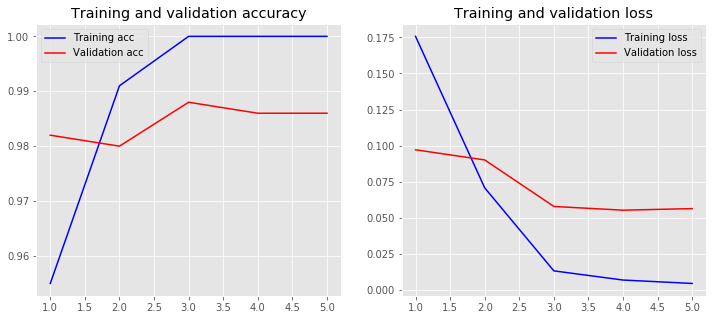

In [11]:
plot_history(history)

Use model to predict classes for test set

In [12]:
results = model.predict_classes(X_test)

In [13]:
kaggle_prediction = pd.DataFrame(columns=['Id', 'Prediction'])

In [14]:
kaggle_prediction['Id'] = test_data['ID']

In [15]:
kaggle_prediction['Prediction'] = results
kaggle_prediction.head(10)

,Id,Prediction
0,1131,0
1,805,1
2,336,1
3,220,0
4,111,0
5,208,1
6,1574,0
7,1324,1
8,692,1
9,1243,1


In [16]:
kaggle_prediction.to_csv('keras_spam_predictions.csv' ,index=False)

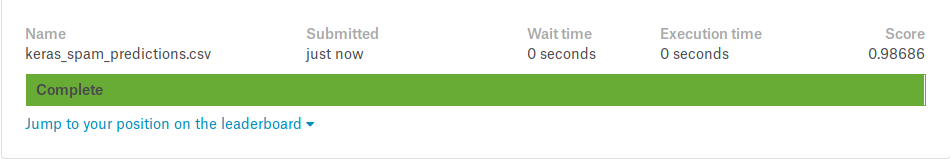